# DEASAFÍO ALGORITMO MACHINE LEARNING

Previamente generamos análisis y visualizaciones a nivel general y específico de los cambios de la liga a lo largo de los años. Este trabajo se centrará hacia los jugadores extranjeros y su presencia en el tiempo, conjuntamente con su rendimiento a lo largo de los años. Hoy buscamos encontrar predecir los valores que corresponden a los puntos por partido de los jugadores extranjeros y observar si anotan más o menos de lo esperado. 


In [1]:
import pandas as pd
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
plt.style.use('fivethirtyeight')

df_NBA = pd.read_csv("/Users/Intel/Desktop/DATA SCIENCE/df_NBA.csv",index_col=0)

MODIFICACIONES PARA EL DESAFÍO

In [2]:
#Dropear columnas 

#drop: player_name
    #team_abbreviation
    #age
    #gp
    #pts
    #reb
    #ast
    #Estas columnas se repitieron con el merge inicial de las dos bases de datos (original+APIs), y son innecesarias. 
    
#Crear columnas

    #assign:pts_tot,ast_tot,reb_tot,stl_tot,blk_tot,tov_tot,pf_tot, position, grupo    
    
NBA=(df_NBA
     .drop(columns=["player_name","team_abbreviation","age","gp",
                                 "pts","reb","ast","gp","reb","USA"])
     .assign(pts_tot=round((df_NBA["GP"]*df_NBA["PTS"])).astype(int),
       ast_tot=round(df_NBA["GP"]*df_NBA["AST"]).astype(int),
        reb_tot=round(df_NBA["GP"]*df_NBA["REB"]).astype(int),
        stl_tot=round(df_NBA["GP"]*df_NBA["STL"]).astype(int),
        blk_tot=round(df_NBA["GP"]*df_NBA["BLK"]).astype(int),
        tov_tot=round(df_NBA["GP"]*df_NBA["TOV"]).astype(int),
        pf_tot=round(df_NBA["GP"]*df_NBA["PF"]).astype(int),
        position = np.where(df_NBA["player_height"] >= 208, 'Center',
                      np.where(df_NBA["player_height"] <= 198, 'Guard', 'Forward')),
        grupo=df_NBA.country.str.contains("USA").replace({True: "USA", False: "World"}))
)


In [3]:
World = NBA[NBA["country"]!="USA"] #Base de datos con jugadores internacionales únicamente (no nacidos en USA)

Para el trabajo se precisan de valores no nulos. En desafíos previos se trató y explicó la presencia de pequeña cantidad de NaN y su ínfima incidencia en el total de los datos y su posterior análisis.

In [4]:
World = World.dropna() 

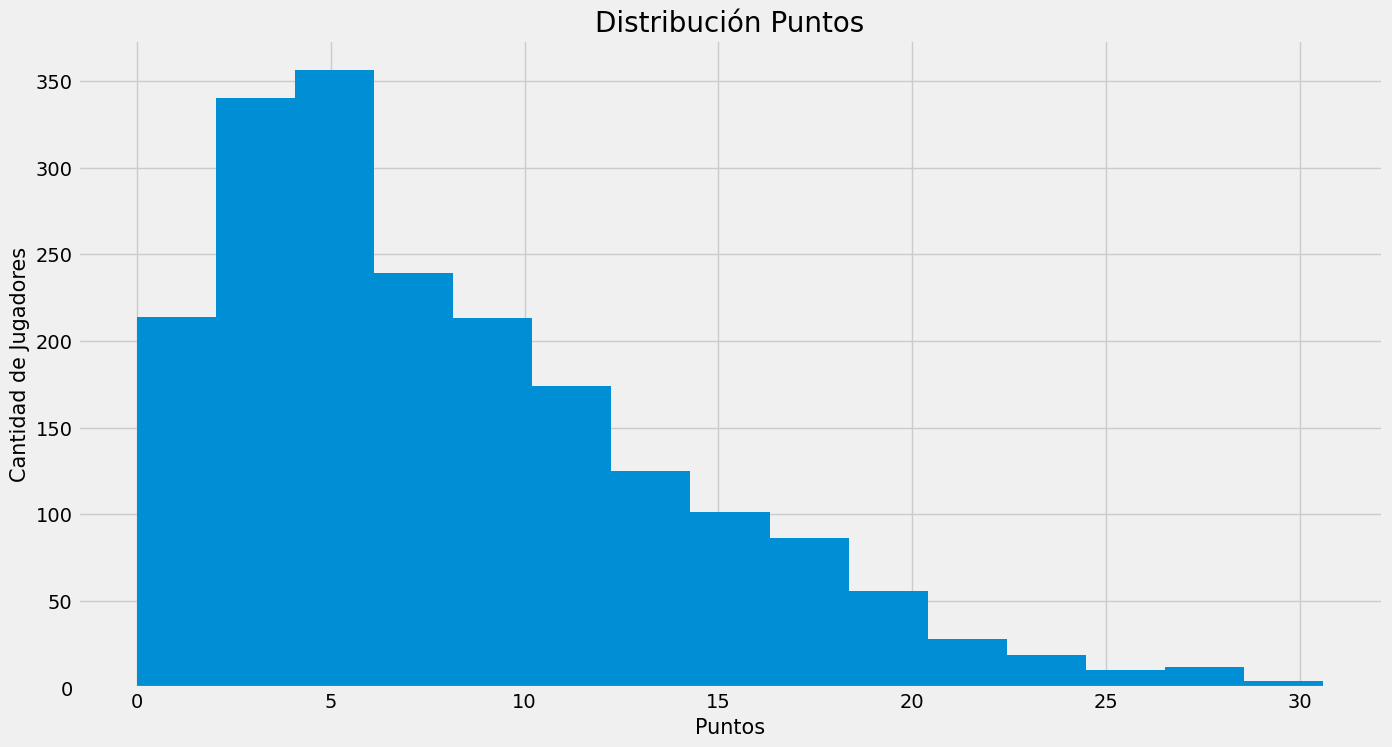

In [5]:
#Cómo es la distribución de puntos? 

plt.figure(figsize = (15,8))
plt.hist(World['PTS'], bins = 15)
plt.xlabel('Puntos', size = 15)
plt.ylabel('Cantidad de Jugadores', size = 15)
plt.title('Distribución Puntos', size = 20);

Vamos a modificar "World" y generar un filtro para aquellos jugadores que hayan participado en igual o más de veinticinco (25) partidos en una temporada. Esto corresponde a un 30% del total de partidos posibles por jugar en cada año.Filtrando por partidos jugados nos permitimos diferenciar a todos aquellos jugadores que: tuvieron lesiones de gravedad, finalizaciones de contrato, paro de jugadores, etc.  
A su vez, filtramos por minutos jugados por partido, para evitar incluir a jugadores que sólo ingresan en periodos de tiempo "Basura", es decir, cuando un partido está por finalizar o la diferencia de puntos entre dos equipos es tan grande que entran a jugar los jóvenes, inexperimentados o jugadores sin minutos.

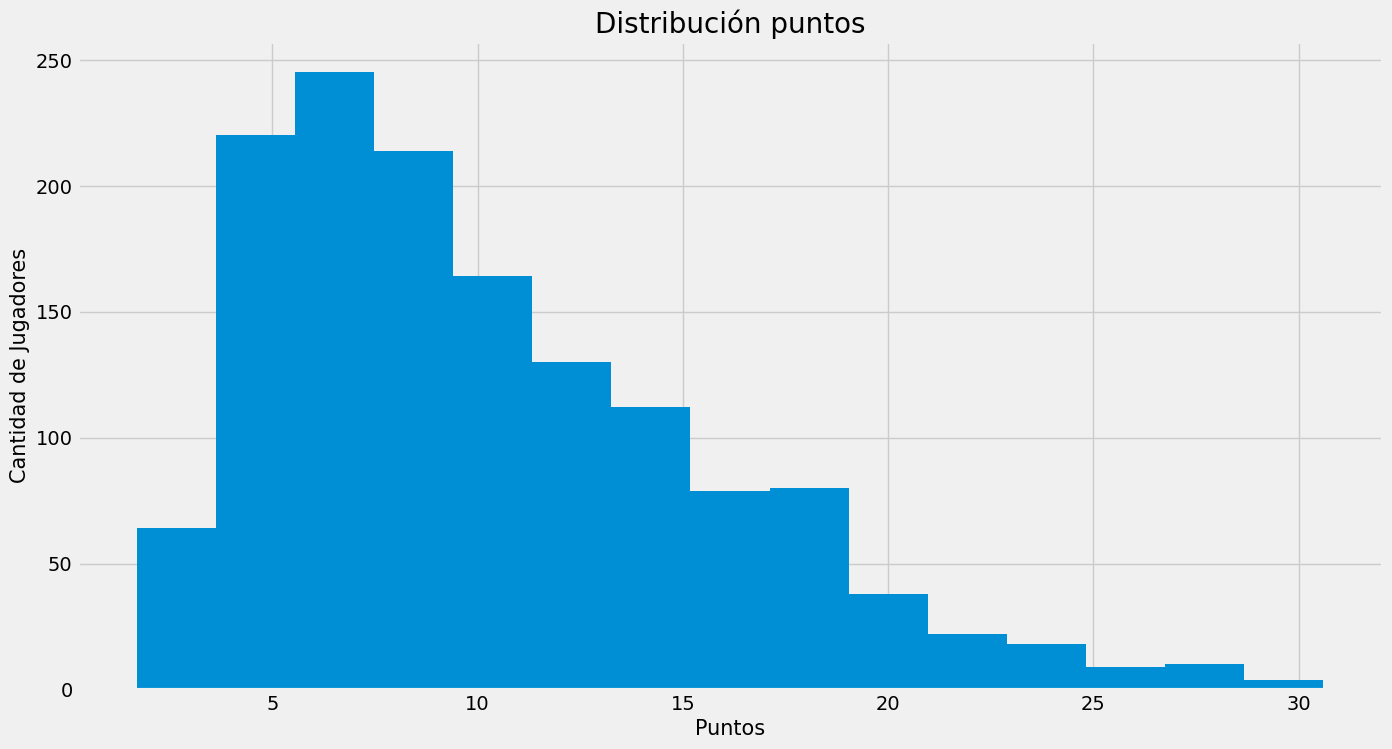

In [6]:
World = World[World['GP'] >= 25] #30% o más partidos jugados en temporada
World = World[World['MIN'] > 12] #20% o más tiempo de juego


plt.figure(figsize = (15,8))
plt.hist(World['PTS'], bins = 15)
plt.xlabel('Puntos', size = 15)
plt.ylabel('Cantidad de Jugadores', size = 15)
plt.title('Distribución puntos', size = 20);

Intervalos de tiempo: Nueva columna para la base de datos en donde segmentamos las temporadas en intervalos de tiempo de cinco años.


In [7]:
World["season"] = pd.to_datetime(World["season"])
World["time_period"] = World["season"].dt.year

# Definimos una función para mapear los años a intervalos de tiempo
def map_time_period(year):
    if year >= 1996 and year <= 2000:
        return "1996-2000"
    elif year >= 2001 and year <= 2005:
        return "2001-2005"
    elif year >= 2006 and year <= 2010:
        return "2006-2010"
    elif year >= 2011 and year <= 2015:
        return "2011-2015"
    elif year >= 2016 and year <= 2021:
        return "2016-2021"
    else:
        return "Unknown"

# Aplicamos la función para crear la nueva columna "time_period"
World["time_period"] = World["time_period"].apply(map_time_period)


CORRELACIÓN DE VARIABLES: PUNTOS 

In [8]:
corr_World = World.corr()['PTS'].reset_index()
corr_World = corr_World.sort_values([('PTS')], ascending = False)
corr_World

#Vamos a considerar valores menores a -0.5 y mayores a 0.5 como correlaciones moderadas a fuertes con respecto a 
#la variable dependiente "PTS"

,index,PTS
26,PTS,1.000000
7,FGM,0.983994
8,FGA,0.976196
36,pts_tot,0.928255
13,FTM,0.871136
6,MIN,0.851305
14,FTA,0.840391
33,usg_pct,0.816998
20,TOV,0.777438
41,tov_tot,0.734390


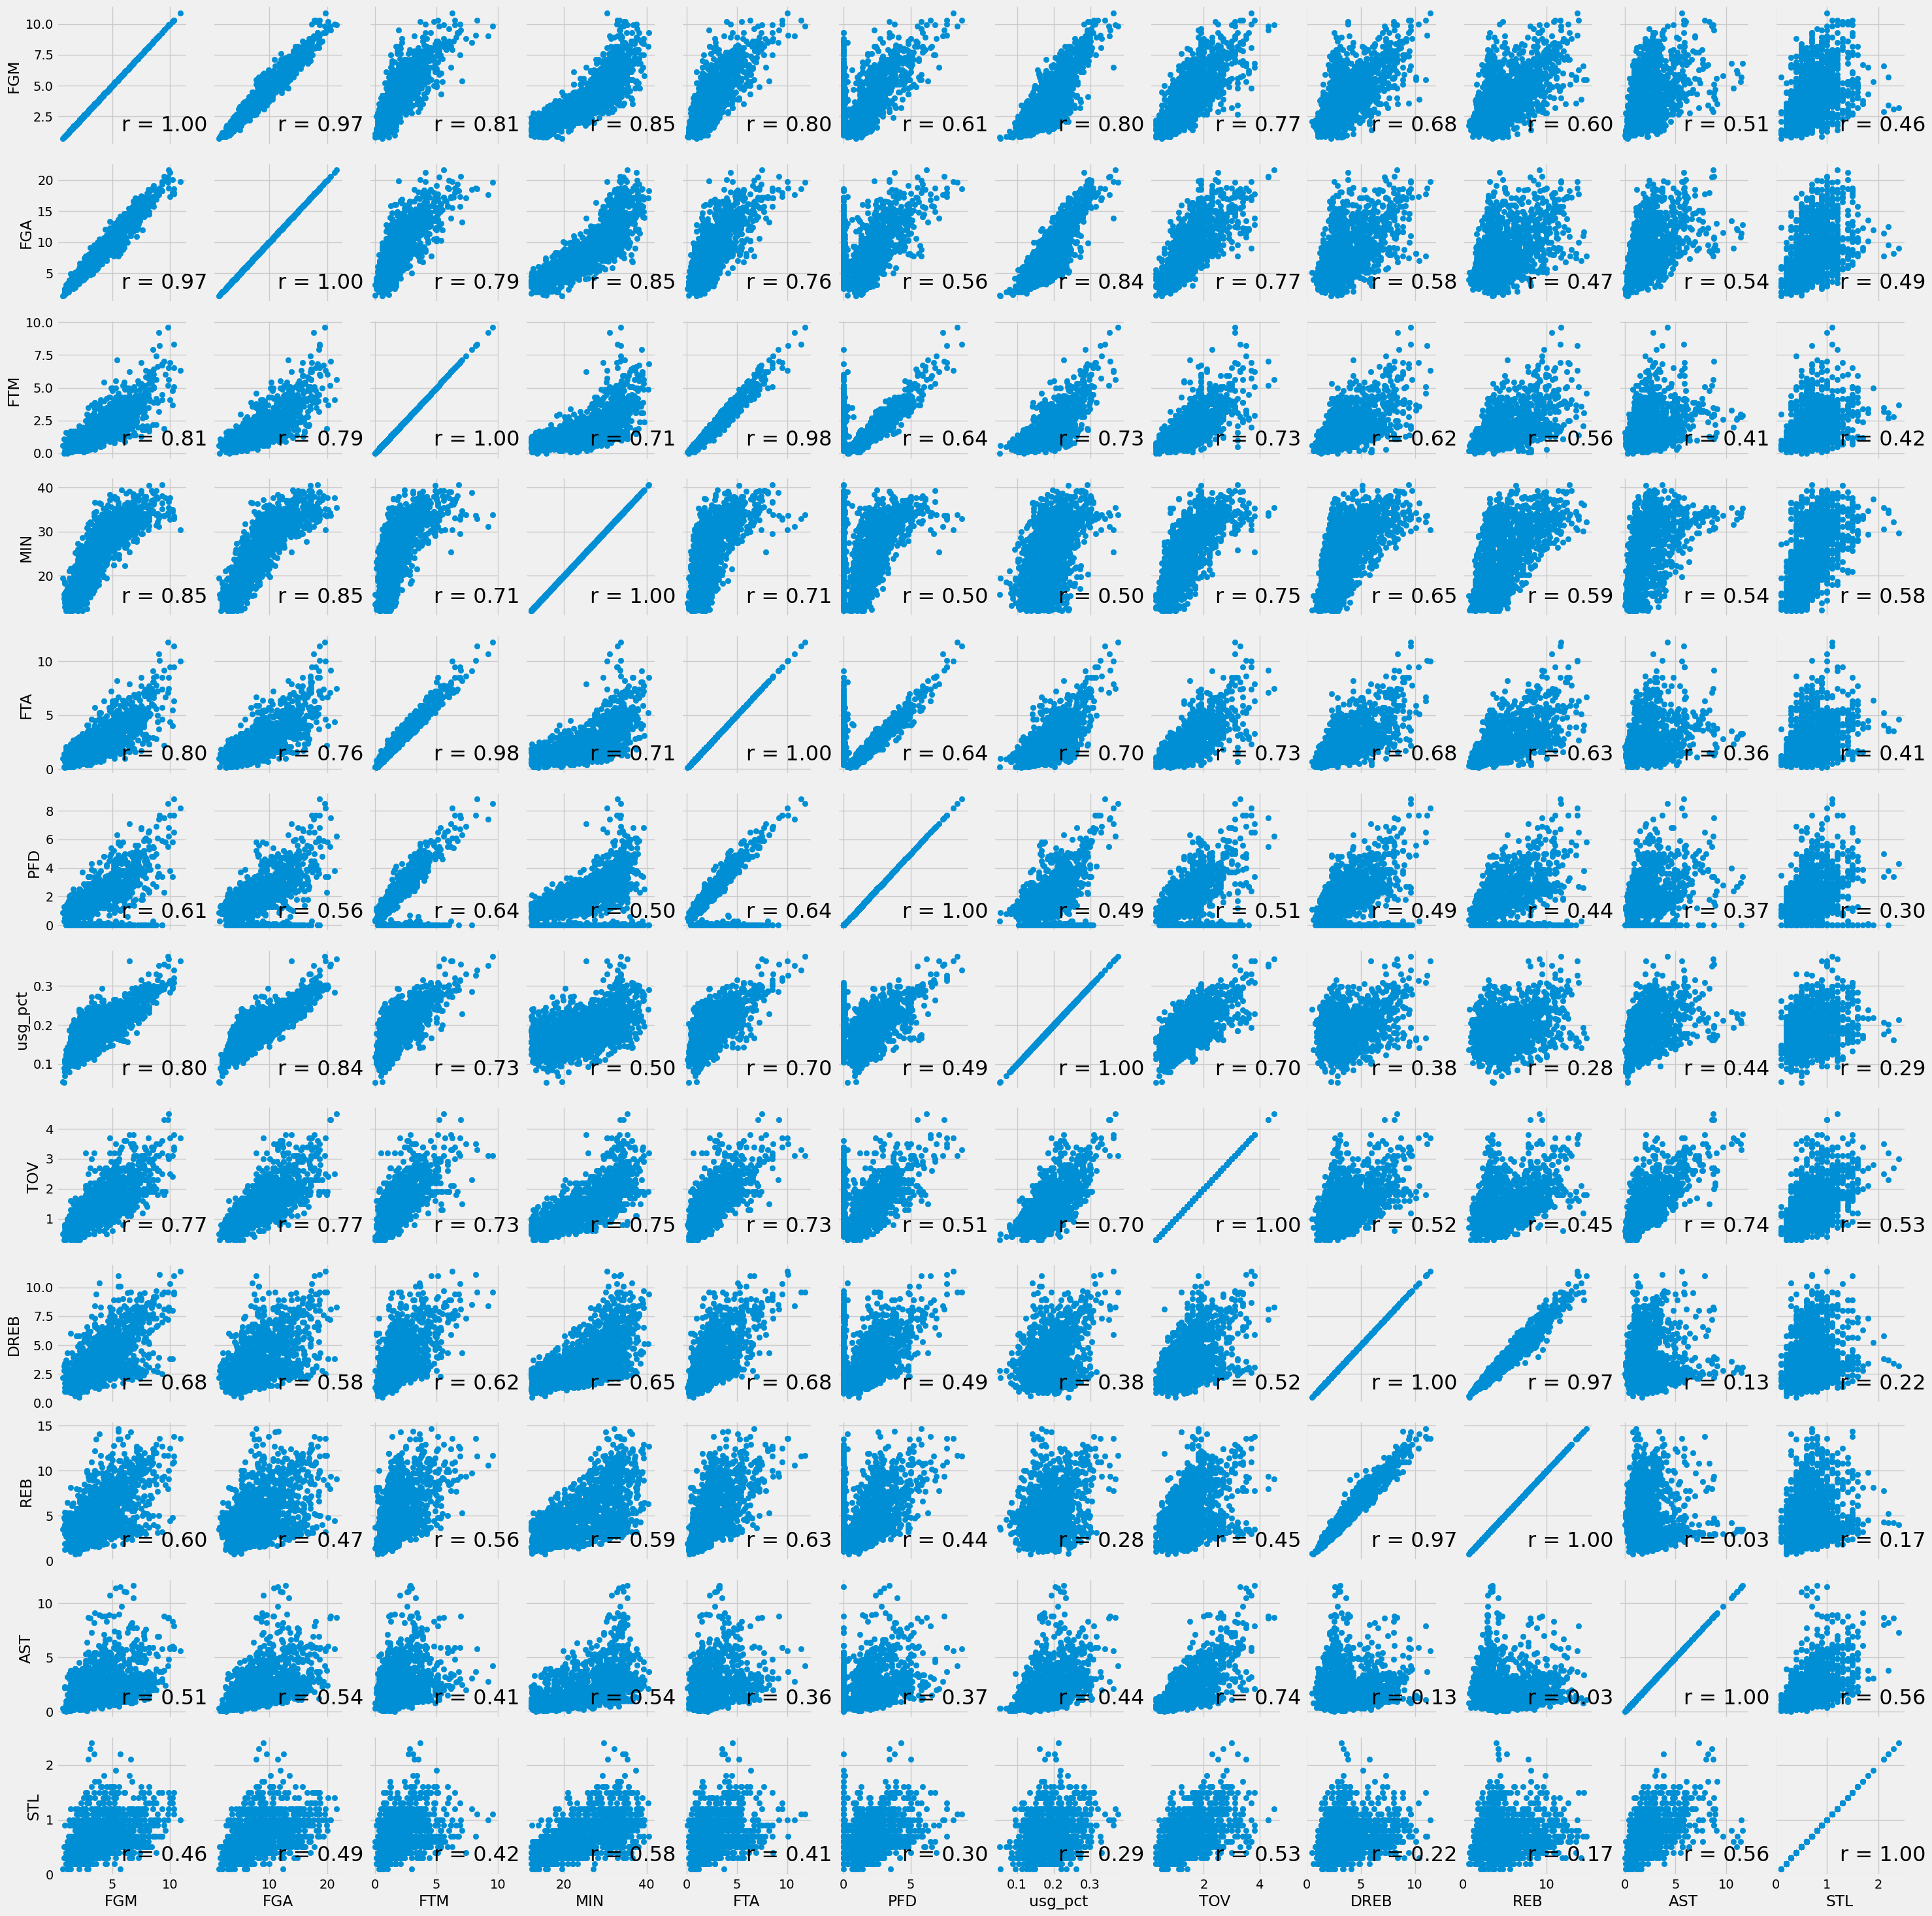

In [9]:
#Corroboramos si hay hipercorrelaciones, si se presentan o no, entre las variables del dataset
corr_World = World[["FGM","FGA","FTM","MIN","FTA","PFD","usg_pct","TOV","DREB","REB","AST","STL"]]


def feature_corr(x, y, **kwargs):
    cor = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(cor),
                xy=(.5, .1),
                xycoords=ax.transAxes,
                size = 23)


plots = sns.PairGrid(corr_World)
plots.map(plt.scatter)
plots.map(feature_corr);

Ciertas cosas a destacar, la correlación entre TOV (Perdidas de balón) y PTS parece ser muy fuerte, sin embargo, esto le escapa al sentido común...mayores perdidas del balón significan menos oportunidades de anotación. En general, jugadores del alta capacidad anotadora (muchos PTS) suelen tener mayor tiempo la posesión del balón, por lo que el usg_pct (porcentaje total de uso) suele ser muy elevado. También es lógico que cuanto más se tenga el balón más se pierda éste, por lo que la correlación entre TOV y usg_pct es alta. Es por eso que vamos a desestimar la variable TOV para la predicción de Puntos.

Sucede igual con otras variables. DRB (Rebotes defensivos) + OREB (Rebotes ofensivos) = REB (Total rebotes). La correlación entre DREB y REB es muy alta (0.97); no sólo eso, parece ser que cuántos más rebotes defensivos mayor posibilidad de anotación. Si bien esto es parcialmente cierto, ya que un rebote asegura una nueva posesión para una consiguiente nueva oportunidad de anotar, esta variable llevada a la práctica no suele incidir en la anotación o no, sino más bien en la posibilidad de ganar un partido. Suele decirse que quien "domina" la estadística del rebote suele ganar el partido.

Una ultima variable a desestimar para la predicción del modelo va a ser PFD (Faltas personales conseguidas). Hay una fuerte dependencia que no puede obviarse con FTA (Tiros libres intentados). Cuando un jugador consigue una falta a su favor, esta suele traducirse en un intento de tiro libre. Ambas variables están muy ligadas una con otra. Debido a eso, decidí únicamente utilizar FTA ya que presente mayor correlación con PTS.

BLKA (Intento de bloqueos) también es desestimada.
Ciertas variables llamaron la atención a la hora de este análisis de correlaciones. Por ejemplo, la edad no aparecería indicar mayor o menor cantidad de puntos, uno pensaría que la experiencia de un jugador se traduciría en mayor cantidad anotadora pero esto pareciera no incidir como se suponía.


# SELECCIÓN DE MODELO

Vamos a utilizar un modelo de regresión lineal

In [10]:
# Creamos datasets de modelos de entrenamiento con las variables elegidas

train, test = train_test_split(World, test_size=0.25, random_state=99)

x_train = train[["FGM","FGA","FTM","FTA","MIN","usg_pct","REB","AST","STL"]]
y_train = train[["PTS"]]

x_test = test[["FGM","FGA","FTM","FTA","MIN","usg_pct","REB","AST","STL"]]
y_test = test[["PTS"]]




In [11]:
model=LinearRegression()
model.fit(x_train,y_train)

print("Test set score: {:.2f}".format(model.score(x_test, y_test)))


Test set score: 0.99


In [12]:
y_train_pred=model.predict(x_train)
y_test_pred=model.predict(x_test)

MÉTRICAS DE EVALUACIÓN

In [13]:
#CALCULO DE R2: R-Cuadrado
print("R2 para el modeo: ", r2_score(y_train,y_train_pred))

R2 para el modeo:  0.9928126046669077


In [14]:
#CALCULO de MAE - Error absoluto medio

#calculo mae para set de entrenamiento
mae_train=mean_absolute_error(y_train,y_train_pred)
print(mae_train)

0.3469092706648294


In [15]:
#calculo mae para set de prueba
mae_test= mean_absolute_error(y_test,y_test_pred)
print(mae_test)

0.37029381156006935


In [16]:
#Calculo RMSE - Error cuadrático medio
rmse_train=np.sqrt(mae_train)
print (rmse_train)

0.5889900429250307


In [17]:
rmse_test=np.sqrt(mae_test)
print (rmse_test)

0.6085177167183132


VISUALIZACIÓN

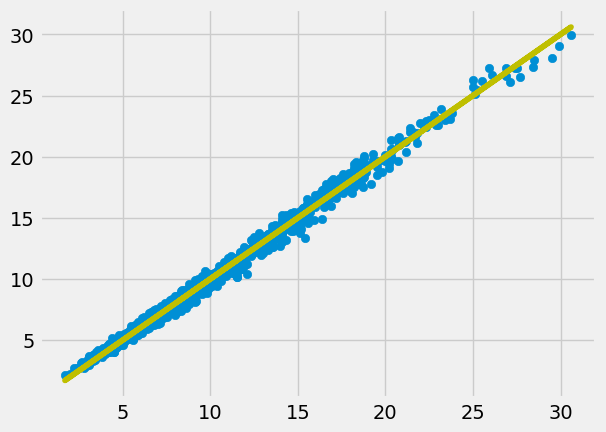

In [18]:
plt.scatter(y_train,y_train_pred)
plt.plot(y_train,y_train,"y")

# VISUALIZACIÓN

In [19]:
# Usameos el modelo que entrenamos para predecir Puntos para cada período de tiempo
prediccion = model.predict(World[["FGM","FGA","FTM","FTA","MIN","usg_pct","REB","AST","STL"]])

# Agregarmos los puntos predecidos para cada jugador a una nueva columna en el "World" dataframe
World['Prediccion_PTS'] = prediccion


In [20]:
# Calculamos la media de Puntos predecidos y Puntos reales, agrupados por intervalos de tiempo
prediccion_pts_mean = World.groupby("time_period")["Prediccion_PTS"].mean()
pts_mean = World.groupby("time_period")["PTS"].mean()

# Generamos un nuevo dataframe para visualizar la diferencia entre lo predecido y lo que sucedió
resultado = pd.DataFrame({"prediccion_pts_mean": prediccion_pts_mean, "pts_mean": pts_mean})
resultado.reset_index(inplace=True)  

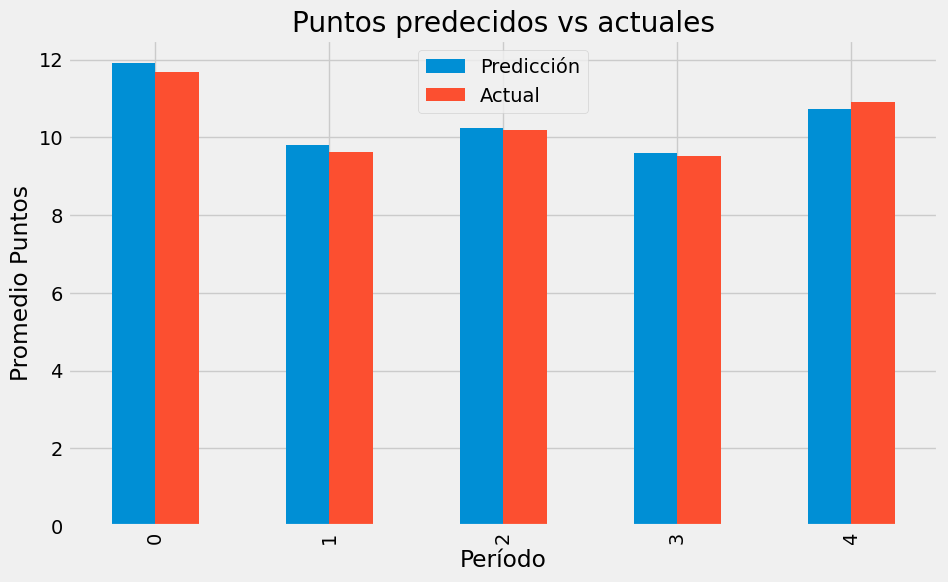

In [21]:
# Generamos el gráfico
ax = resultado.plot(kind="bar", figsize=(10, 6))
ax.set_xlabel("Período")
ax.set_ylabel("Promedio Puntos")
ax.set_title("Puntos predecidos vs actuales")
ax.legend(["Predicción", "Actual"])
plt.show()


En el último período (2016 a 2021) se observa por primera vez un desempeño anotador por encima de lo esperado. Esta puede ser una de las razones por las que los jugadores internacionales están cada vez más asentados en la liga, generan mayor cantidad de puntos y de manera eficiente por sobre lo esperado. El periodo 0 (1996 a 2000) puede llegar a ser engañoso. Ya vimos como el número de jugadores internacionales que hacen presencia en la liga ha ido aumentando con los años de manera considerada, sobre todo a partir del nuevo siglo, previo a eso el número de jugadores no nacionales (USA) era minúsculo por lo que la relevancia de ese período no debe ser tomada de manera absoluta sino parcial.

# NUEVA ENTREGA: NUEVAS VARIABLES

Vamos a probar con más y distintas variablespara ver como trabajan los distintos modelos a la hora de predecir puntos.
Se van a generar test de entrenamientos mediante regresión, y calcular las mismas métricas de evaluación que se hicieron en la entrega anterior.

Luego, se generará una comparación de los modelos para evaluar su eficacia.

# MODELO 2

Vamos a usar un modelos más simplificado que el original donde sólo se tomaran en cuenta las variables más directas a la ahora de generar puntos. Cantidad de tiros de campo, cantidad de tiros libres, minutos jugados, y porcentaje de uso del balón. No se van a tomar en cuenta los tiros anotados sino únicamente los intentados como también se ignorarán variables secundarias como los rebotes y asistencias. Estos van a ser utilizados para el tercer modelo.

In [22]:
train2, test2 = train_test_split(World, test_size=0.25, random_state=99)

x_train2 = train2[["FGA","FTA","MIN","usg_pct"]]
y_train2 = train2[["PTS"]]

x_test2 = test2[["FGA","FTA","MIN","usg_pct"]]
y_test2 = test2[["PTS"]]


In [23]:
model2=LinearRegression()
model2.fit(x_train2,y_train2)

print("Test set score: {:.2f}".format(model2.score(x_test2, y_test2)))


Test set score: 0.98


In [24]:
y_train_pred2=model2.predict(x_train2)
y_test_pred2=model2.predict(x_test2)

In [25]:
#CALCULO DE R2: R-Cuadrado
print("R2 para el modeo: ", r2_score(y_train2,y_train_pred2))

R2 para el modeo:  0.9792084592585446


In [26]:
#CALCULO de MAE - Error absoluto medio

#calculo mae para set de entrenamiento
mae_train2=mean_absolute_error(y_train2,y_train_pred2)
print(mae_train2)

0.5737985812359278


In [27]:
#calculo mae para set de prueba
mae_test2= mean_absolute_error(y_test2,y_test_pred2)
print(mae_test2)

0.6495701560656825


In [28]:
#Calculo RMSE - Error cuadrático medio
rmse_train2=np.sqrt(mae_train2)
print (rmse_train2)

0.7574949380926105


In [29]:
rmse_test2=np.sqrt(mae_test2)
print (rmse_test2)

0.8059591528518567


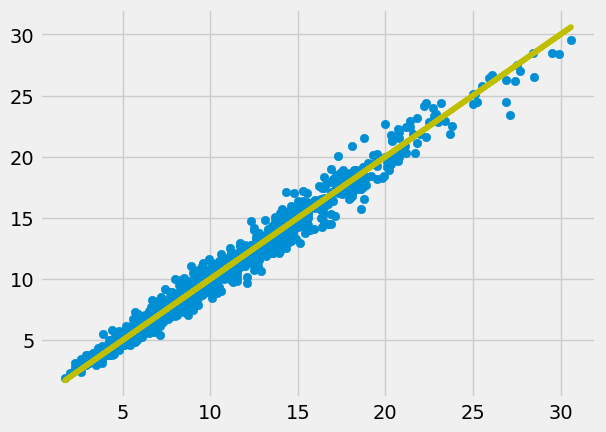

In [30]:
plt.scatter(y_train2,y_train_pred2)
plt.plot(y_train2,y_train2,"y")

In [31]:
# Usameos el modelo 2 que entrenamos para predecir Puntos para cada período de tiempo
prediccion2 = model2.predict(World[["FGA","FTA","MIN","usg_pct"]])

# Agregarmos los puntos predecidos para cada jugador a una nueva columna en el "World" dataframe
World['Prediccion_PTS2'] = prediccion2


# MODELO 3

Para esta evaluación tomamos variables de tipo "ofensivas" y secundarias a la hora de generación de puntos. Notar que al ignorar tiros de campo y tiros libres, se va a desviar de lo esperado y lo real.

In [32]:
train3, test3 = train_test_split(World, test_size=0.25, random_state=99)

x_train3 = train3[["OREB","AST","TOV","MIN","usg_pct"]]
y_train3= train3[["PTS"]]

x_test3 = test3[["OREB","AST","TOV","MIN","usg_pct"]]
y_test3 = test3[["PTS"]]

In [33]:
model3=LinearRegression()
model3.fit(x_train3,y_train3)

print("Test set score: {:.2f}".format(model3.score(x_test3, y_test3)))


Test set score: 0.93


In [34]:
y_train_pred3=model3.predict(x_train3)
y_test_pred3=model3.predict(x_test3)

In [35]:
#CALCULO DE R2: R-Cuadrado
print("R2 para el modeo: ", r2_score(y_train3,y_train_pred3))

R2 para el modeo:  0.9324662330132134


In [36]:
#CALCULO de MAE - Error absoluto medio

#calculo mae para set de entrenamiento
mae_train3=mean_absolute_error(y_train3,y_train_pred3)
print(mae_train3)

1.0718326719278823


In [37]:
#calculo mae para set de prueba
mae_test3= mean_absolute_error(y_test3,y_test_pred3)
print(mae_test3)

1.1668801421339134


In [38]:
#Calculo RMSE - Error cuadrático medio
rmse_train3=np.sqrt(mae_train3)
print (rmse_train3)

1.035293519697618


In [39]:
rmse_test3=np.sqrt(mae_test3)
print (rmse_test3)

1.080222265153757


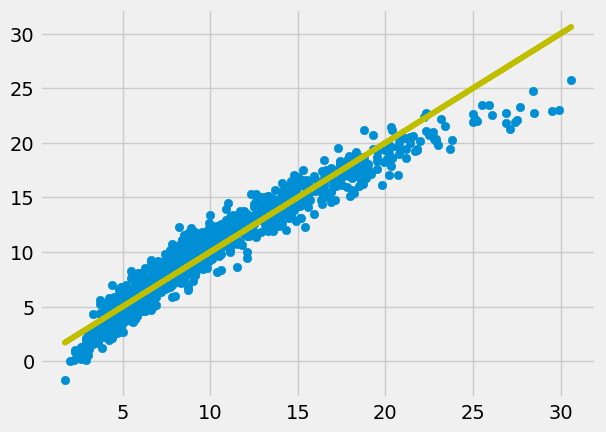

In [40]:
plt.scatter(y_train3,y_train_pred3)
plt.plot(y_train3,y_train3,"y")

In [41]:
# Usameos el modelo 3 que entrenamos para predecir Puntos para cada período de tiempo
prediccion3 = model3.predict(World[["OREB","AST","TOV","MIN","usg_pct"]])

# Agregarmos los puntos predecidos para cada jugador a una nueva columna en el "World" dataframe
World['Prediccion_PTS3'] = prediccion3


# COMPARACIÓN DE MODELOS DE ENTRENAMIENTO

In [42]:
World.groupby("time_period")[["PTS", "Prediccion_PTS", "Prediccion_PTS2", "Prediccion_PTS3"]].mean()

,PTS,Prediccion_PTS,Prediccion_PTS2,Prediccion_PTS3
time_period,,,,
1996-2000,11.677632,11.905846,12.284903,12.580040
2001-2005,9.633486,9.817187,9.951205,10.172981
2006-2010,10.183274,10.246754,10.123081,10.461194
2011-2015,9.513095,9.606067,9.638036,10.002521
2016-2021,10.914056,10.741054,10.688346,10.106271


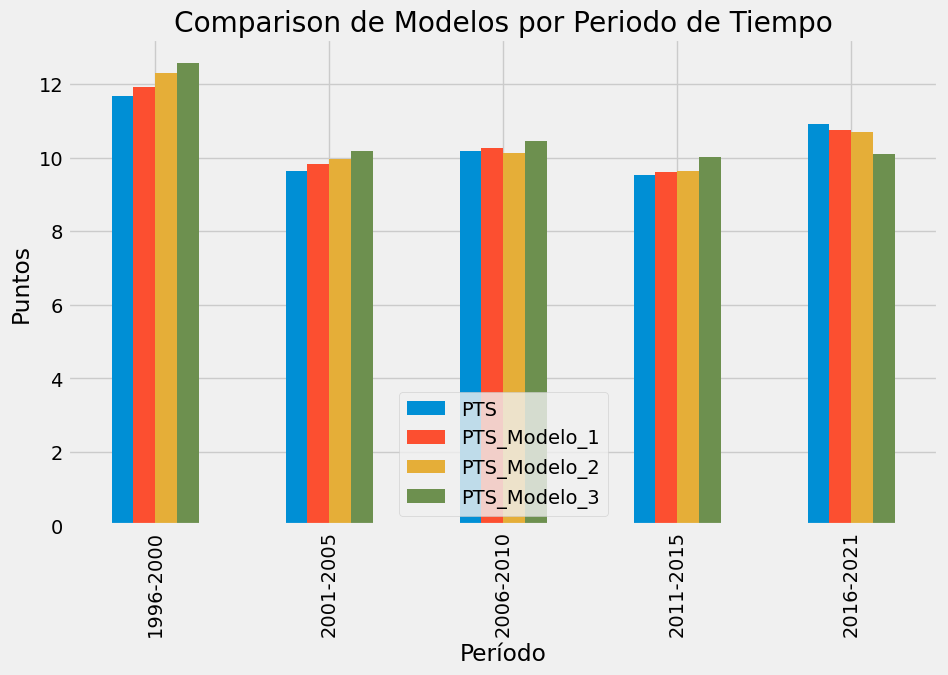

In [43]:
#Generación de gráfico para compraración de modelos
grafico_modelos= World.groupby("time_period")[["PTS", "Prediccion_PTS", "Prediccion_PTS2", "Prediccion_PTS3"]].mean()

# Plot a bar chart
grafico_modelos.plot(kind="bar", figsize=(10, 6))

# Set the title and labels
plt.title("Comparison de Modelos por Periodo de Tiempo")
plt.xlabel("Período")
plt.ylabel("Puntos")

# Display the legend
plt.legend(["PTS", "PTS_Modelo_1", "PTS_Modelo_2", "PTS_Modelo_3"])

# Show the plot
plt.show()


Observamos que el modelo 3 es mucho más impreciso y genera mayores errores de predicción y de métricas que los modelos 1-2

Los primeros dos modelos generan los mejores resultados ajustandose con más precisón a los puntos reales. Tal vez el primero demasiado, pudiendo haber un caso de overfitting.